In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

In [ ]:
folder_path_no = "/content/drive/MyDrive/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"
folder_path_yes = "/content/drive/MyDrive/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"

folder_no = os.listdir(folder_path_no)
folder_yes = os.listdir(folder_path_yes)

print(len(folder_no))
print(len(folder_yes))

98
155


In [ ]:
folder_no[:4]

['N22.JPG', 'no 95.jpg', 'no 2.jpg', 'no 92.jpg']

## Target Labels

In [ ]:
## We can consider
   # No Tumor  >> 0
   # Yes Tumor >> 1

no_label = [0]*len(folder_no)
yes_label = [1]*len(folder_yes)

labels = no_label + yes_label
print(len(labels))

253


In [ ]:
print(labels[:5])
print(labels[-5:])

[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]


# Image Augmentation and then Saving the Augmented Dataset


In [ ]:
import os
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Create directories to save augmented images
save_dir_no = '/content/augmented_images/no'
save_dir_yes = '/content/augmented_images/yes'
os.makedirs(save_dir_no, exist_ok=True)
os.makedirs(save_dir_yes, exist_ok=True)

# Initialize lists to store labels and filenames
augmented_labels = []
image_filenames = []
desired_number_of_images = 1500  # You can adjust this

# Function to save augmented images and labels
def save_augmented_images(img, folder_path, label, img_prefix):
    image = Image.open(folder_path + img)
    image = image.resize((224, 224))
    image = image.convert("RGB")
    image_array = np.array(image)
    image_array = image_array.reshape((1,) + image_array.shape)  # Add extra dimension for batch

    for i, (batch, labels_batch) in enumerate(datagen.flow(image_array, np.array([label]), batch_size=1)):
        augmented_image = batch[0].astype('uint8')  # Convert back to uint8 format
        img_filename = f"{img_prefix}_aug_{i}.jpg"
        save_path = os.path.join(save_dir_no if label == 0 else save_dir_yes, img_filename)

        # Save the image to disk
        Image.fromarray(augmented_image).save(save_path)

        # Store label and filename
        augmented_labels.append(label)
        image_filenames.append(save_path)

        if len(image_filenames) >= desired_number_of_images:  # Stop when desired number of images is reached
            break

# Augment images from the "no" folder
for img in folder_no:
    save_augmented_images(img, "/content/drive/MyDrive/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/", 0, 'no')

# Augment images from the "yes" folder
for img in folder_yes:
    save_augmented_images(img, "/content/drive/MyDrive/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/", 1, 'yes')

# Save the labels and filenames to a CSV file
df = pd.DataFrame({'image': image_filenames, 'label': augmented_labels})
df.to_csv('/content/augmented_images/augmented_dataset.csv', index=False)


In [ ]:
!zip -r /content/augmented_images.zip /content/augmented_images

  adding: content/augmented_images/ (stored 0%)
  adding: content/augmented_images/augmented_dataset.csv (deflated 95%)
  adding: content/augmented_images/yes/ (stored 0%)
  adding: content/augmented_images/yes/yes_aug_0.jpg (deflated 2%)
  adding: content/augmented_images/no/ (stored 0%)
  adding: content/augmented_images/no/no_aug_564.jpg (deflated 4%)
  adding: content/augmented_images/no/no_aug_425.jpg (deflated 3%)
  adding: content/augmented_images/no/no_aug_224.jpg (deflated 4%)
  adding: content/augmented_images/no/no_aug_438.jpg (deflated 6%)
  adding: content/augmented_images/no/no_aug_1116.jpg (deflated 5%)
  adding: content/augmented_images/no/no_aug_1077.jpg (deflated 3%)
  adding: content/augmented_images/no/no_aug_853.jpg (deflated 4%)
  adding: content/augmented_images/no/no_aug_1326.jpg (deflated 4%)
  adding: content/augmented_images/no/no_aug_1442.jpg (deflated 4%)
  adding: content/augmented_images/no/no_aug_1206.jpg (deflated 3%)
  adding: content/augmented_images/

In [ ]:
from google.colab import files
files.download('/content/augmented_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Directory where augmented images are saved
save_dir = '/content/augmented_images'

# Count number of files in the directory
num_images = len([f for f in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, f))])
print(f"Number of augmented images: {num_images}")

Number of augmented images: 1


#IMAGE AUGMENTATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Initialize lists to store augmented data and labels
augmented_data = []
augmented_labels = []
desired_number_of_images = 1500
# Augment images from the "no" folder
for img in folder_no:
    image = Image.open("/content/drive/MyDrive/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/"+img)
    image = image.resize((224, 224))
    image = image.convert("RGB")
    image_array = np.array(image)
    image_array = image_array.reshape((1,) + image_array.shape)  # Add extra dimension for batch
    label = 0  # Assign label 0 for "No Tumor"
    for batch, labels_batch in datagen.flow(image_array, np.array([label]), batch_size=1):
        augmented_data.append(batch[0])
        augmented_labels.append(labels_batch[0])
        if len(augmented_data) >= desired_number_of_images:
            break

# Augment images from the "yes" folder
for img in folder_yes:
    image = Image.open("/content/drive/MyDrive/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/"+img)
    image = image.resize((224, 224))
    image = image.convert("RGB")
    image_array = np.array(image)
    image_array = image_array.reshape((1,) + image_array.shape)  # Add extra dimension for batch
    label = 1  # Assign label 1 for "Tumor"
    for batch, labels_batch in datagen.flow(image_array, np.array([label]), batch_size=1):
        augmented_data.append(batch[0])
        augmented_labels.append(labels_batch[0])
        if len(augmented_data) >= desired_number_of_images:
            break

## Split The data

In [ ]:
X = np.array(augmented_data)
y = np.array(augmented_labels)

y_train = tf.keras.utils.to_categorical(y, num_classes=2)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.10, random_state=50,stratify=y)

## Scale The Data

## Create CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.optimizers import Adam
pre_trained_model = tf.keras.applications.MobileNet(include_top=False,
                                                    input_shape=(224, 224, 3),
                                                    weights='imagenet')


for layer in pre_trained_model.layers[:1]:
    layer.trainable = False
for layer in pre_trained_model.layers[1:]:
    layer.trainable = True


model = tf.keras.models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 16
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision() , tf.keras.metrics.Recall()]
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy' , metrics])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(X_train)

history=model.fit(datagen.flow(X_train,y_train), epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 45s 449ms/step - loss: 0.4760 - accuracy: 0.9251 - auc: 0.9667 - precision: 0.9251 - recall: 0.9251 - val_loss: 0.1157 - val_accuracy: 0.9375 - val_auc: 0.9938 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 2/10
50/50 [==============================] - 22s 444ms/step - loss: 0.0816 - accuracy: 0.9613 - auc: 0.9952 - precision: 0.9613 - recall: 0.9613 - val_loss: 0.2044 - val_accuracy: 0.9375 - val_auc: 0.9581 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 3/10
50/50 [==============================] - 21s 414ms/step - loss: 0.0767 - accuracy: 0.9702 - auc: 0.9910 - precision: 0.9702 - recall: 0.9702 - val_loss: 0.1171 - val_accuracy: 0.9659 - val_auc: 0.9814 - val_precision: 0.9659 - val_recall: 0.9659
Epoch 4/10
50/50 [==============================] - 22s 446ms/step - loss: 0.0744 - accuracy: 0.9714 - auc: 0.9923 - precision: 0.9714 - recall: 0.9714 - val_loss: 0.2168 - val_accuracy: 0.9375 - val_auc: 0.9535 - val_precision: 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              205524992 
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                      

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_test,y_test))  # batch_size=32

Epoch 1/10
50/50 [==============================] - 10s 192ms/step - loss: 0.0322 - accuracy: 0.9879 - auc: 0.9971 - precision: 0.9879 - recall: 0.9879 - val_loss: 0.2601 - val_accuracy: 0.9659 - val_auc: 0.9819 - val_precision: 0.9659 - val_recall: 0.9659
Epoch 2/10
50/50 [==============================] - 9s 180ms/step - loss: 0.0218 - accuracy: 0.9924 - auc: 0.9991 - precision: 0.9924 - recall: 0.9924 - val_loss: 0.3345 - val_accuracy: 0.9659 - val_auc: 0.9647 - val_precision: 0.9659 - val_recall: 0.9659
Epoch 3/10
50/50 [==============================] - 9s 178ms/step - loss: 0.0169 - accuracy: 0.9937 - auc: 0.9980 - precision: 0.9937 - recall: 0.9937 - val_loss: 0.2435 - val_accuracy: 0.9489 - val_auc: 0.9758 - val_precision: 0.9489 - val_recall: 0.9489
Epoch 4/10
50/50 [==============================] - 9s 178ms/step - loss: 0.0123 - accuracy: 0.9962 - auc: 0.9987 - precision: 0.9962 - recall: 0.9962 - val_loss: 0.1880 - val_accuracy: 0.9773 - val_auc: 0.9826 - val_precision: 0.9

## Model Evaluation on test Data

In [ ]:
# loss, acc = model.evaluate(X_test,y_test)
# print("Accuracy on Test Data:",acc)

# Evaluate the model on the test data
results = model.evaluate(X_test, y_test)

# Print the loss and accuracy
print("Loss on Test Data:", results[0])
print("Accuracy on Test Data:", results[1])
print(results[:])


6/6 [==============================] - 0s 52ms/step - loss: 0.2572 - accuracy: 0.9830 - auc: 0.9830 - precision: 0.9830 - recall: 0.9830
Loss on Test Data: 0.2571920156478882
Accuracy on Test Data: 0.9829545617103577
[0.2571920156478882, 0.9829545617103577, 0.9829545021057129, 0.9829545617103577, 0.9829545617103577]


In [ ]:
# y_pred = model.predict(X_test)
# y_pred = [1 if i>=0.5 else 0 for i in y_pred]

# y_pred[:6]

# Perform thresholding operation on each prediction in y_pred
# threshold = 0.5
# y_pred = [1 if pred >= threshold else 0 for pred in y_pred]

# # Print the first 6 predictions after thresholding
# print(y_pred[:6])

import numpy as np
y_pred = model.predict(X_test).astype(int)
# Flatten the predictions array to obtain single values for each prediction
y_pred_flat = np.ravel(y_pred)

# Perform thresholding operation on each prediction in y_pred_flat
threshold = 0.5
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_flat]

# Print the first 6 predictions after thresholding
print(y_pred_binary[:6])


6/6 [==============================] - 0s 49ms/step
[1, 0, 1, 0, 1, 0]


In [ ]:
y_test[:10]   # Actual Label

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
y_pred[:10]  # Predicted Label

## Using Pretrained Model

In [ ]:
path = "https://tfhub.dev/google/efficientnet/b0/classification/1" # 224x224x3
efficient_model = hub.KerasLayer(path,input_shape=(224,224,3),trainable=False)


eff_model = Sequential()
eff_model.add(efficient_model)
eff_model.add(Dense(units=1, activation="sigmoid"))

eff_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              5330564   
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 5331565 (20.34 MB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


In [ ]:
eff_model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_4 = eff_model.fit(x_train_scaled , y_train ,
           epochs=10, validation_data=(x_test_scaled,y_test))

Epoch 1/10
8/8 [==============================] - 23s 2s/step - loss: 0.5716 - accuracy: 0.6872 - val_loss: 0.4720 - val_accuracy: 0.7692
Epoch 2/10
8/8 [==============================] - 16s 2s/step - loss: 0.4410 - accuracy: 0.7665 - val_loss: 0.4052 - val_accuracy: 0.9231
Epoch 3/10
8/8 [==============================] - 17s 2s/step - loss: 0.3888 - accuracy: 0.8326 - val_loss: 0.3712 - val_accuracy: 0.9615
Epoch 4/10
8/8 [==============================] - 16s 2s/step - loss: 0.3432 - accuracy: 0.8458 - val_loss: 0.3607 - val_accuracy: 0.9231
Epoch 5/10
8/8 [==============================] - 17s 2s/step - loss: 0.3046 - accuracy: 0.8987 - val_loss: 0.3340 - val_accuracy: 0.9231
Epoch 6/10
8/8 [==============================] - 18s 2s/step - loss: 0.3012 - accuracy: 0.8899 - val_loss: 0.3270 - val_accuracy: 0.9231
Epoch 7/10
8/8 [==============================] - 18s 2s/step - loss: 0.2859 - accuracy: 0.8634 - val_loss: 0.3604 - val_accuracy: 0.8462
Epoch 8/10
8/8 [==================

In [ ]:
loss, acc = eff_model.evaluate(x_test_scaled,y_test)
print("Accuracy on Test Data:",acc)

1/1 [==============================] - 2s 2s/step - loss: 0.3139 - accuracy: 0.8846
Accuracy on Test Data: 0.8846153616905212


In [ ]:
y_pred = eff_model.predict(x_test_scaled)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

1/1 [==============================] - 2s 2s/step


In [ ]:
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print()
print("Classification Report:\n",classification_report(y_test,y_pred))

Confusion Matrix:
 [[11  1]
 [ 2 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.92      0.86      0.89        14

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.88        26



## Actual & Predicted Image on EfficientNet Model

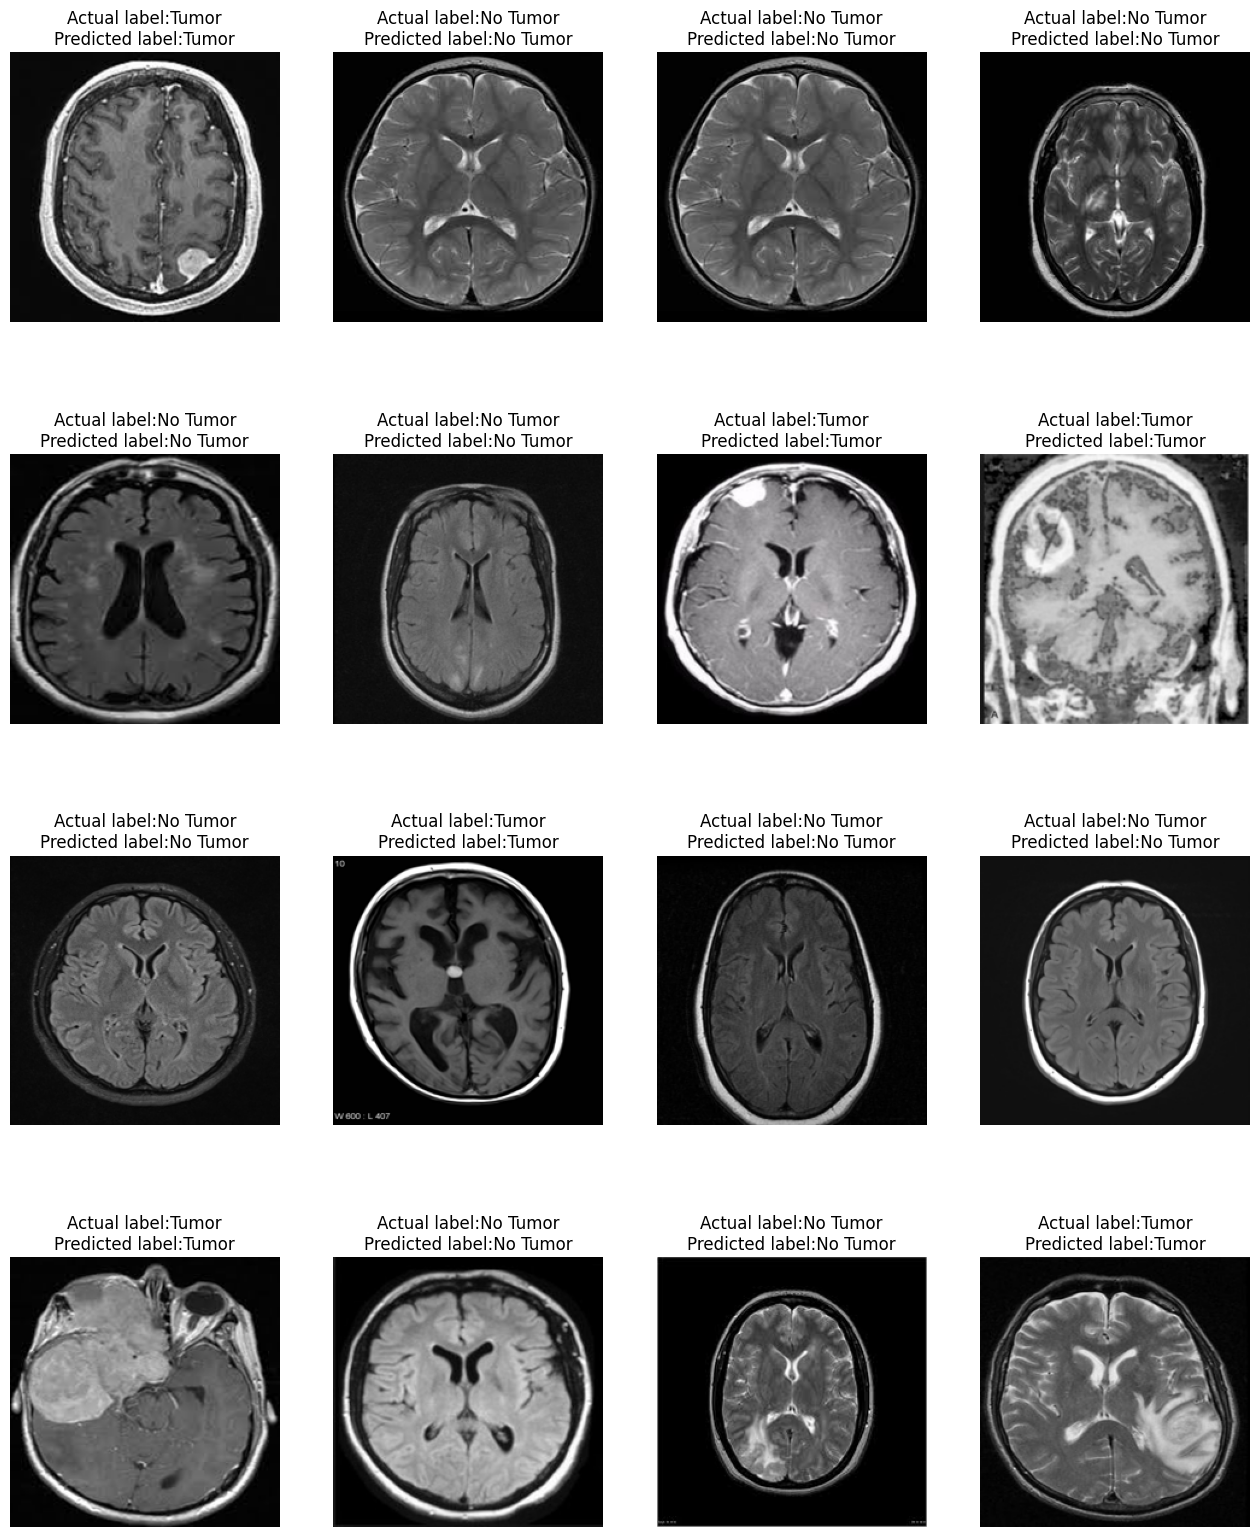

In [ ]:
class_labels=["No Tumor","Tumor"]
plt.figure(figsize=(16,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_test[i])
    plt.title(f"Actual label:{class_labels[y_test[i]]}\nPredicted label:{class_labels[y_pred[i]]}")
    plt.axis("off")

In [ ]:
model.save("BrainTumor.h5")

This above line of code is for saving the model in hdf5 format which have the extension as ".h5"
